In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [21]:
data_path = "../data/combined_data.csv"

In [22]:
df = pd.read_csv(data_path)

In [25]:
df[['Speed Follower','Speed Leader']]

,Speed Follower,Speed Leader
0,55.310,55.130
1,55.170,55.255
2,55.030,55.380
3,55.040,55.430
4,55.050,55.480
...,...,...
741167,95.560,95.130
741168,95.450,95.125
741169,95.340,95.120
741170,95.375,95.055


### Divide the dataset based on the gap setting

In [5]:
medium_gap_df = df[df['gap_setting']=='Medium']

In [6]:
medium_gap_df.shape

(181318, 12)

In [7]:
short_gap_df = df[df['gap_setting']=='Short']
long_gap_df = df[df['gap_setting']=='Long']
xlong_gap_df = df[df['gap_setting']=='XLong']

In [8]:
medium_gap_df.shape,short_gap_df.shape,long_gap_df.shape,xlong_gap_df.shape

((181318, 12), (184718, 12), (181868, 12), (193268, 12))

In [9]:
medium_gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181318 entries, 181868 to 363185
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             181318 non-null  int64  
 1   Time                   181318 non-null  float64
 2   Speed Follower         181318 non-null  float64
 3   Speed Leader           181318 non-null  float64
 4   Smooth Speed Follower  181318 non-null  float64
 5   Smooth Speed Leader    181318 non-null  float64
 6   Spacing                181318 non-null  float64
 7   file_path              181318 non-null  object 
 8   gap_setting            181318 non-null  object 
 9   desired_speed          181318 non-null  int64  
 10  free_flow_speed        181318 non-null  int64  
 11  speed_fluctuation      181318 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 18.0+ MB


### Calibration

In [10]:
# initial_params = [30.0, 1.5, 2.0, 1.0, 1.5]


# Define the IDM model
def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    v0, T, s0, a_max, b = params
    spacing = [initial_spacing]
    speed = [initial_speed]
    for t in range(1, len(time)):
        dt = time[t] - time[t-1]
        delta_v = lead_speed[t-1] - speed[-1]
        s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
        v_new = speed[-1] + a * dt
        s_new = spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt
        spacing.append(s_new)
        speed.append(v_new)
    return np.array(spacing), np.array(speed)


# import numpy as np

# def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
#     v0, T, s0, a_max, b = params
#     spacing = [initial_spacing]
#     speed = [initial_speed]
    
#     for t in range(1, len(time)):
#         dt = time[t] - time[t-1]
#         delta_v = lead_speed[t-1] - speed[-1]
        
#         # Compute desired spacing
#         s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        
#         # Compute acceleration with stability check
#         a = a_max * (1 - (speed[-1] / v0)**2 - (s_star / (spacing[-1] + 1e-5))**2)
        
#         # Update speed and spacing
#         v_new = max(speed[-1] + a * dt, 0)  # Ensure speed is non-negative
#         s_new = max(spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt + 0.5 * a * dt**2, s0)  # Ensure spacing is at least s0
        
#         spacing.append(s_new)
#         speed.append(v_new)
    
#     return np.array(spacing), np.array(speed)


In [11]:
# (time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed

In [12]:
# Define the objective function (spacing RMSE)
def objective(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    simulated_spacing, _ = idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))
    return rmse

In [13]:
def calibaration_start(df):
    
    # Split the data into six subsets (each 200 seconds long)
    subset_length = int(200 / 0.02)  # 200 seconds, assuming 0.02-second time steps
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    print(f"Number of Subset: {len(subsets)}")
    # Calibrate on each subset
    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"-------------------Calibrating on subset {i+1}-------------------")

        # Extract data for the subset
        time_subset = subset['Time'].values
        lead_speed_subset = subset['Speed Leader'].values
        follow_speed_subset = subset['Speed Follower'].values
        experimental_spacing_subset = subset['Spacing'].values

        # Initial conditions
        initial_spacing = experimental_spacing_subset[0]
        initial_speed = follow_speed_subset[0]

        # Initial guess for parameters
#         initial_params = [0.5, 0.5, 2.0, 1.5]
        
        initial_params = [25, 1.0, 1.0, 1.0, 1.67]

        # Bounds for parameters
#         bounds = [(0, None), (0, None), (0, None), (0, None)]
        bounds = [(25.0, 45.0), (1, 2.5), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]
#         bounds = [(20.0, 30.0), (1.0, 3.0), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]

        # Run optimization
        result = minimize(objective, initial_params, args=(time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed),
                         bounds=bounds, method='L-BFGS-B')

        # Simulate with the calibrated parameters
        simulated_spacing, _ = idm_model(result.x, time_subset, lead_speed_subset, initial_spacing, initial_speed)

        print(f"Simulated Spacing: {len(simulated_spacing)}")
        print(f"Experimental Spacing: {len(experimental_spacing_subset)}")
        rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

        print(f"Subset {i+1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")
    print("-------------------------------------------------")
    print(f"Best params: {best_params} \nBest RMSE : {best_rmse}")
    return best_params,best_rmse

def test_and_viz_full_dataset(df, best_params, limit=None):

    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
#     time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0], follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing)**2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")
    
    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]
    
    
    print(time)
    print(experimental_spacing)
    print(simulated_spacing_full)
    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='-', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='-', linewidth=1)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
# from sklearn.metrics import mean_squared_error, r2_score

# # Compute RMSE for spacing
# spacing_rmse = np.sqrt(mean_squared_error(experimental_spacing, simulated_spacing))
# print(f"Spacing RMSE: {spacing_rmse:.4f}")

# # Compute RMSE for speed
# speed_rmse = np.sqrt(mean_squared_error(follow_speed, simulated_speed))
# print(f"Speed RMSE: {speed_rmse:.4f}")

# # Compute R² for spacing
# spacing_r2 = r2_score(experimental_spacing, simulated_spacing)
# print(f"Spacing R²: {spacing_r2:.4f}")

# # Compute R² for speed
# speed_r2 = r2_score(follow_speed, simulated_speed)
# print(f"Speed R²: {speed_r2:.4f}")

In [15]:
medium_gap_best_params,medium_gap_best_rmse = calibaration_start(medium_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------


/tmp/ipykernel_204767/3004835227.py:13: RuntimeWarning: overflow encountered in scalar power
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_204767/3004835227.py:13: RuntimeWarning: invalid value encountered in scalar divide
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_204767/3004835227.py:12: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
/tmp/ipykernel_204767/2752833236.py:4: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: nan
Params: [43.87107713  1.          1.          1.92982707  1.98137277]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 17942.7290
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 3-------------------


/tmp/ipykernel_204767/2073643371.py:45: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 6992.3188
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: nan
Params: [25.    1.    1.    1.    1.67]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 12847.4835
Params: [25.    1.    1.    1.    1.67]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: nan
Params: [25.    1.    1.    1.    1.67]
-------------------------------------------------
Best params: [45.  1.  1.  2.  2.] 
Best RMSE : 6992.3187545128485


-----------------------------------------------------------------------------
Full dataset RMSE: 34188.3265
[0.0000e+00 2.0000e-02 4.0000e-02 ... 1.6996e+02 1.6998e+02 1.7000e+02]
[25.82558311 25.81255193 25.79952078 ... 25.56019387 25.57988146
 25.60137151]
[ 25.82558311  25.80358311  25.7834897  ... 408.62926    408.59989333
 408.57030465]


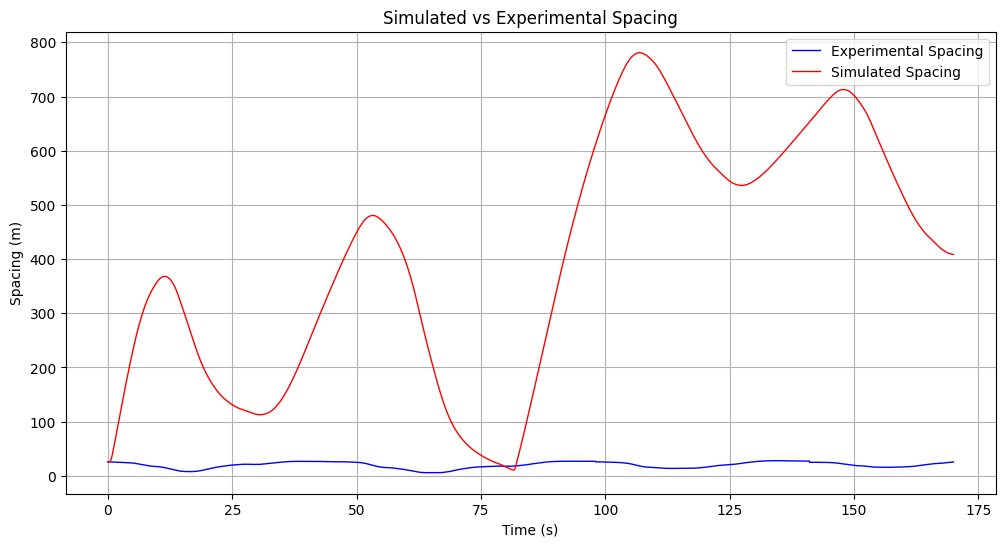

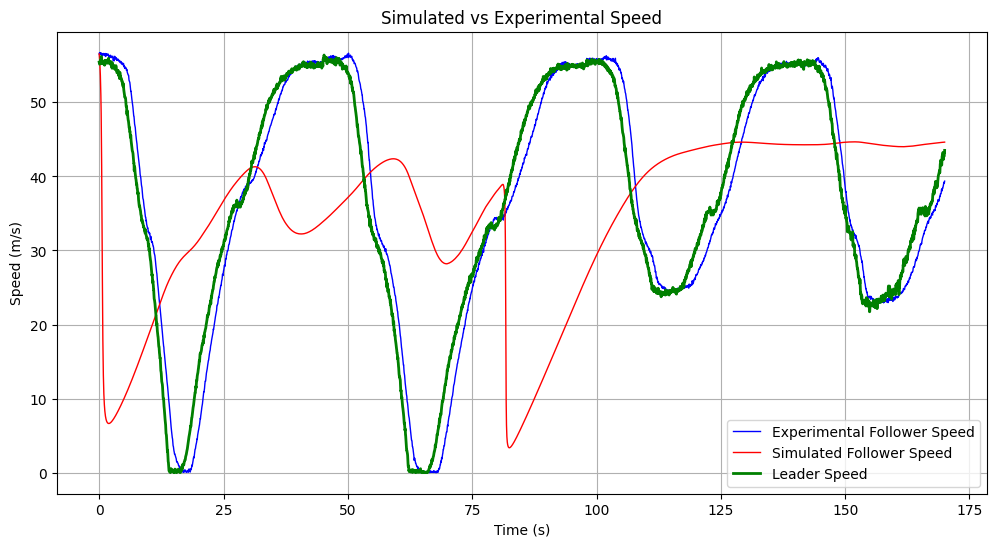

In [16]:
test_and_viz_full_dataset(medium_gap_df,medium_gap_best_params,limit=(0, 170))

In [17]:
medium_gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181318 entries, 181868 to 363185
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             181318 non-null  int64  
 1   Time                   181318 non-null  float64
 2   Speed Follower         181318 non-null  float64
 3   Speed Leader           181318 non-null  float64
 4   Smooth Speed Follower  181318 non-null  float64
 5   Smooth Speed Leader    181318 non-null  float64
 6   Spacing                181318 non-null  float64
 7   file_path              181318 non-null  object 
 8   gap_setting            181318 non-null  object 
 9   desired_speed          181318 non-null  int64  
 10  free_flow_speed        181318 non-null  int64  
 11  speed_fluctuation      181318 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 18.0+ MB


In [18]:
short_gap_best_params,short_gap_best_rmse = calibaration_start(short_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 2606.7279
Params: [45.          1.          1.          1.36936001  2.        ]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 9394.6731
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 3-------------------


/tmp/ipykernel_204767/3004835227.py:12: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
/tmp/ipykernel_204767/3004835227.py:13: RuntimeWarning: overflow encountered in scalar power
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_204767/3004835227.py:13: RuntimeWarning: invalid value encountered in scalar divide
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_204767/2752833236.py:4: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: nan
Params: [25.    1.    1.    1.    1.67]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 20234.1718
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 5-------------------


/tmp/ipykernel_204767/2073643371.py:45: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 15159.8142
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: 12660.3005
Params: [45.  1.  1.  2.  2.]
-------------------------------------------------
Best params: [45.          1.          1.          1.36936001  2.        ] 
Best RMSE : 2606.727888172991


-----------------------------------------------------------------------------
Full dataset RMSE: 34950.0180
[0.000e+00 2.000e-02 4.000e-02 ... 6.996e+01 6.998e+01 7.000e+01]
[21.2202309  21.22029281 21.22035619 ...  8.48612142  8.49636033
  8.51265119]
[ 21.2202309   21.2282309   21.24113411 ... 169.06434927 168.52340073
 167.98498954]


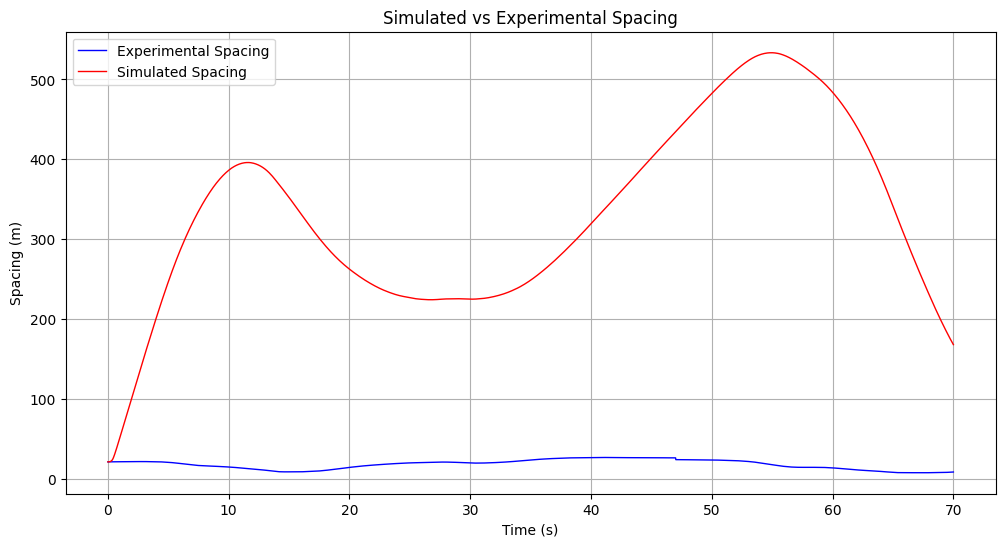

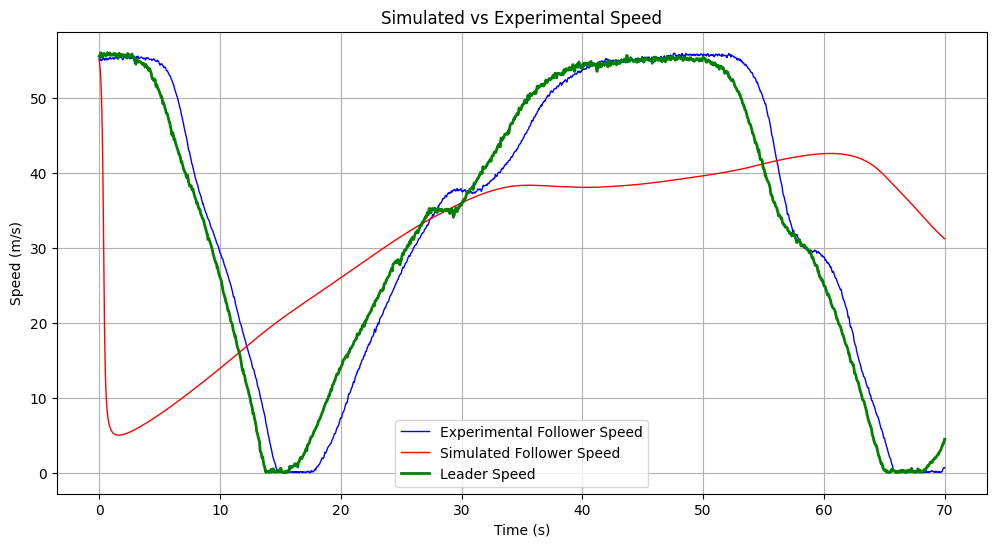

In [19]:
test_and_viz_full_dataset(short_gap_df,short_gap_best_params,limit=(0, 70))

In [22]:
long_gap_best_params,long_gap_best_rms = calibaration_start(long_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 1700.6163
Params: [45.          1.34950754  1.          2.          2.        ]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 17529.8694
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 12134.8684
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 18340.6475
Params: [45.  1.  1.  2.  2.]
-------------------Calibrating on subset 5-------------------


/tmp/ipykernel_90061/3190628504.py:12: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
/tmp/ipykernel_90061/3190628504.py:13: RuntimeWarning: overflow encountered in scalar power
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_90061/3190628504.py:13: RuntimeWarning: invalid value encountered in scalar divide
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_90061/2752833236.py:4: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 8748.1532
Params: [33.3   2.    1.6   2.    1.67]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: nan
Params: [33.3   2.    1.6   2.    1.67]
-------------------------------------------------
Best params: [45.          1.34950754  1.          2.          2.        ] 
Best RMSE : 1700.6163121558056


/tmp/ipykernel_90061/2887167487.py:45: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))


-----------------------------------------------------------------------------
Full dataset RMSE: 33524.7007


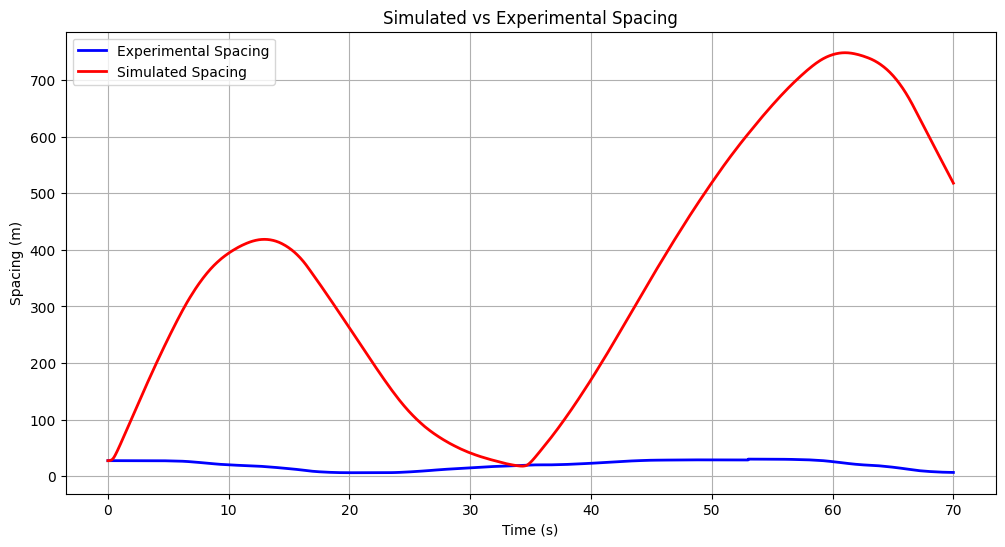

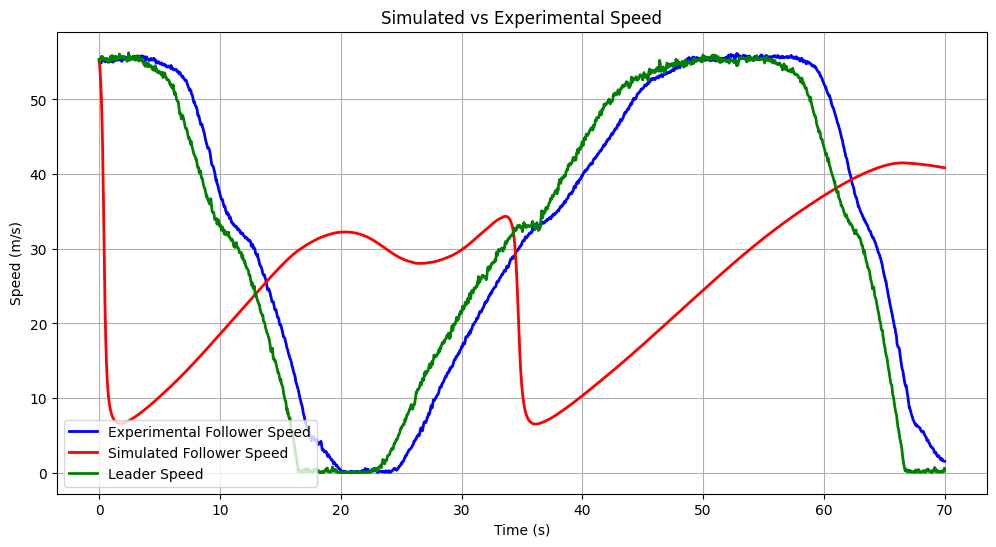

In [23]:
test_and_viz_full_dataset(long_gap_df,long_gap_best_params,limit=(0, 70))

In [24]:
xlong_gap_best_params,xlong_gap_best_rms = calibaration_start(xlong_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 2020.4973
Params: [44.87870319  1.          1.          2.          2.        ]
-------------------Calibrating on subset 2-------------------


/tmp/ipykernel_90061/3190628504.py:13: RuntimeWarning: overflow encountered in scalar power
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_90061/3190628504.py:13: RuntimeWarning: invalid value encountered in scalar divide
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: nan
Params: [33.3   2.    1.6   2.    1.67]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 4545.3228
Params: [45.          1.12415976  5.          2.          2.        ]
-------------------Calibrating on subset 4-------------------


/tmp/ipykernel_90061/3190628504.py:12: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
/tmp/ipykernel_90061/2752833236.py:4: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: nan
Params: [33.3   2.    1.6   2.    1.67]
-------------------Calibrating on subset 5-------------------


/tmp/ipykernel_90061/2887167487.py:45: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 22723.0609
Params: [35.45213999  1.          1.          2.          2.        ]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: 139034.0543
Params: [33.3   2.    1.6   2.    1.67]
-------------------------------------------------
Best params: [44.87870319  1.          1.          2.          2.        ] 
Best RMSE : 2020.497299251296


-----------------------------------------------------------------------------
Full dataset RMSE: 36507.8772


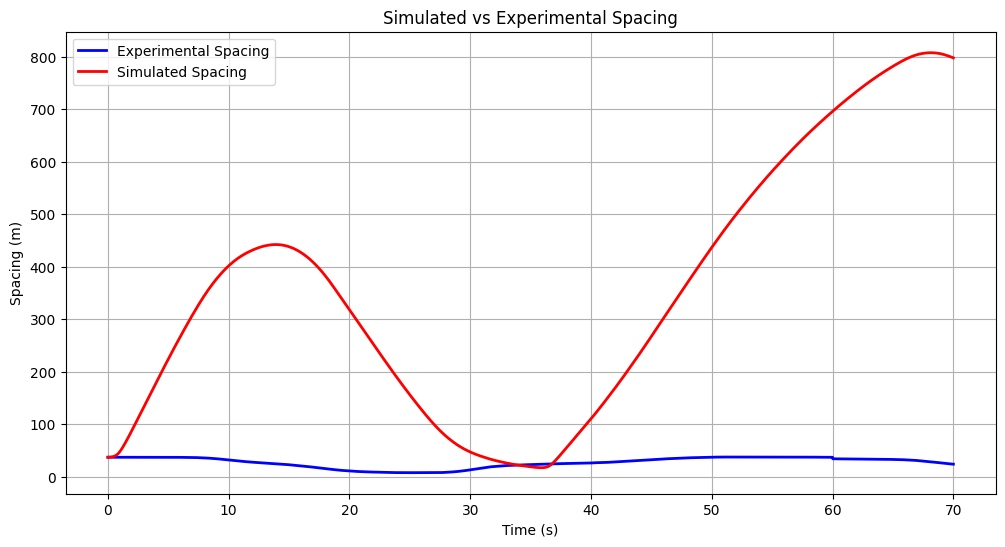

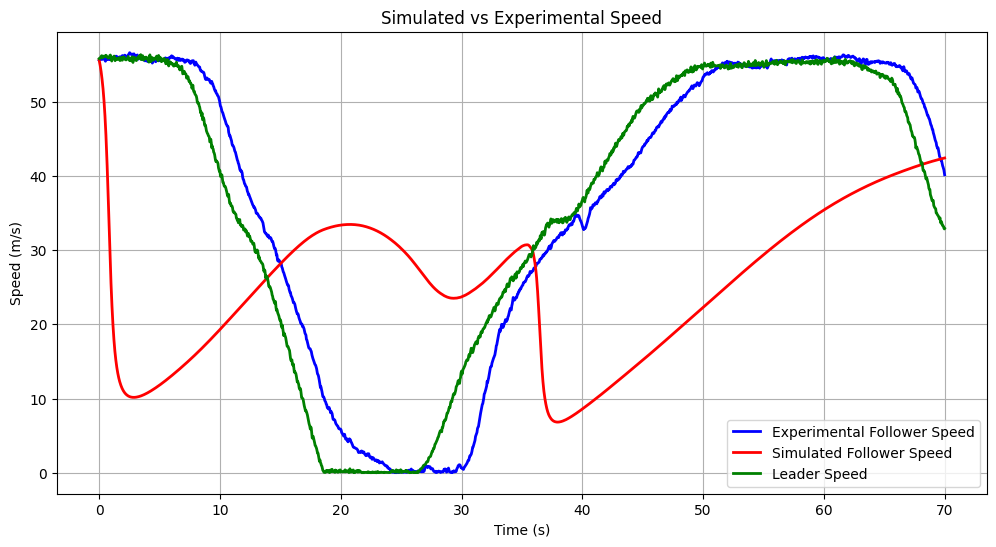

In [25]:
test_and_viz_full_dataset(xlong_gap_df,xlong_gap_best_params,limit=(0, 70))

-----------------------------------------------------------------------------
Full dataset RMSE: 36507.8772


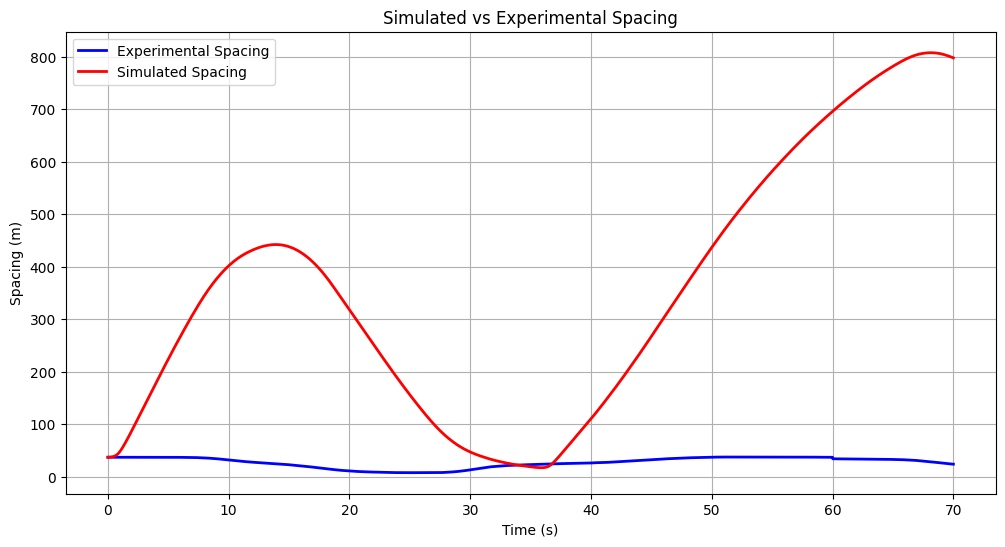

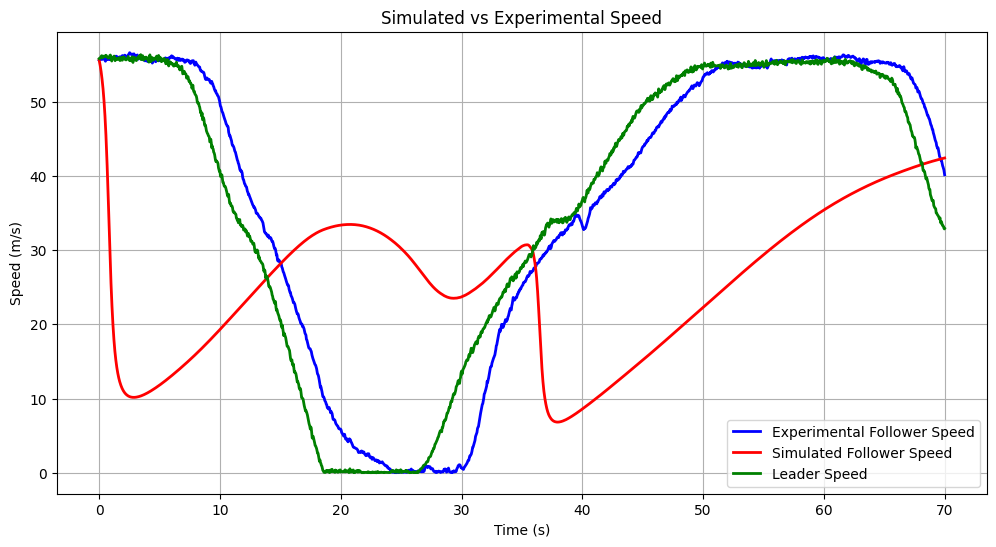

In [26]:
test_and_viz_full_dataset(xlong_gap_df, xlong_gap_best_params, limit=(0, 70))

In [28]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the IDM model
def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    """
    Simulate the IDM car-following model.
    
    Parameters:
        params (list): IDM parameters [v0, T, s0, a_max, b].
        time (np.array): Time array.
        lead_speed (np.array): Lead vehicle speed.
        initial_spacing (float): Initial spacing.
        initial_speed (float): Initial speed.
    
    Returns:
        spacing (np.array): Simulated spacing.
        speed (np.array): Simulated speed.
    """
    v0, T, s0, a_max, b = params
    spacing = [initial_spacing]
    speed = [initial_speed]
    for t in range(1, len(time)):
        dt = time[t] - time[t-1]
        delta_v = lead_speed[t-1] - speed[-1]
        s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
        v_new = speed[-1] + a * dt
        s_new = spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt
        spacing.append(s_new)
        speed.append(v_new)
    return np.array(spacing), np.array(speed)

# Define the objective function (spacing RMSE)
def objective(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    """
    Calculate the spacing RMSE for the IDM model.
    
    Parameters:
        params (list): IDM parameters [v0, T, s0, a_max, b].
        time (np.array): Time array.
        lead_speed (np.array): Lead vehicle speed.
        experimental_spacing (np.array): Experimental spacing data.
        initial_spacing (float): Initial spacing.
        initial_speed (float): Initial speed.
    
    Returns:
        rmse (float): Root Mean Square Error.
    """
    simulated_spacing, _ = idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))
    return rmse

# Load your dataset into a DataFrame
# Example: df = pd.read_csv('your_data_file.csv')

# Extract relevant columns
time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
lead_speed = df['Speed Leader'].values
follow_speed = df['Speed Follower'].values
experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

# Split the data into six subsets (each 200 seconds long)
subset_length = int(200 / 0.02)  # 200 seconds, assuming 0.02-second time steps
num_subsets = 6
subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

# Calibrate on each subset
best_rmse = np.inf
best_params = None

for i, subset in enumerate(subsets):
    print(f"Calibrating on subset {i+1}...")
    
    # Extract data for the subset
    time_subset = np.arange(0, len(subset)) * 0.02
    time_subset = subset['time'].values
    lead_speed_subset = subset['Speed Leader'].values
    follow_speed_subset = subset['Speed Follower'].values
    experimental_spacing_subset = subset['Spacing'].values
    
    # Initial conditions
    initial_spacing = experimental_spacing_subset[0]
    initial_speed = follow_speed_subset[0]
    
    # Initial guess for parameters
    initial_params = [30.0, 1.5, 2.0, 1.0, 1.5]  # [v0, T, s0, a_max, b]
    
    # Bounds for parameters
    bounds = [(20.0, 40.0), (0.5, 2.5), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]
    
    # Run optimization
    result = minimize(objective, initial_params, args=(time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed),
                     bounds=bounds, method='L-BFGS-B')
    
    # Simulate with the calibrated parameters
    simulated_spacing, _ = idm_model(result.x, time_subset, lead_speed_subset, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))
    
    # Check if this is the best model so far
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = result.x
    
    print(f"Subset {i+1} RMSE: {rmse:.4f}")

# Best-fit parameters
print("Best-fit parameters:", best_params)

# Test the best model on the entire dataset
simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0], follow_speed[0])
rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing)**2))
print(f"Full dataset RMSE: {rmse_full:.4f}")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=2)
plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Spacing (m)')
plt.title('Simulated vs Experimental Spacing (Full Dataset)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=2)
plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='--', linewidth=2)
plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle=':', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Simulated vs Experimental Speed (Full Dataset)')
plt.legend()
plt.grid(True)
plt.show()

Calibrating on subset 1...


KeyError: 'time'